In [272]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
!pip install ptitprince
import ptitprince as pt
import pandas as pd
import numpy as np


In [273]:
import matplotlib.pylab as plt
import seaborn as sns

In [274]:

from datetime import datetime
#para buscar los mejores hiperarametros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
 
#con esto se hace kflod
from sklearn.model_selection import StratifiedKFold

In [275]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [276]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [277]:
 
id='1MfnxlPGSmr-i1up_2iKCkrBIMcDHomnK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.csv')

In [278]:
id='1kZt5ZN2eAyeNEIWLh6lGckgyDIxpHN4f'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test.csv')

In [279]:
test=pd.read_csv('test.csv')

In [280]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

In [281]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [282]:
#y_test = random_search.predict_proba(test)
#results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
#results_df.to_csv('submission-random-grid-search-xgb-porto-01.csv', index=False)


In [283]:
class Modelo():
  def __init__(self ):
    pass



  def splitTrainTarget(self,entrenamientoFeatureTarget):
    #separo  mi dataframe en X= feature engineri e y= target
    target='Stage'
    listColumns=entrenamientoFeatureTarget.columns.to_list()
    listColumns.remove('Stage')
    listColumns.remove('Opportunity_ID')
    listColumns
    X,y=entrenamientoFeatureTarget[listColumns], entrenamientoFeatureTarget[target]
    print("las columnas del train son {} y del target son  {}".format(X.columns , y.name ))
    return X,y

  def SplitTrainTest(self,X,y):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=123 )

    return X_train, X_test, y_train, y_test


  def entrenarYPredecirMismoSetEntrenamiento(self,X_train,y_train,X_test): 
    self.modelo.fit(X_train, y_train)
    preds =  self.modelo.predict(X_test)
    return preds

  def errorSetEntrenamiento( self,X_train,y_train,X_test,y_test):
     preds= self.entrenarYPredecirMismoSetEntrenamiento( X_train,y_train,X_test)
     rmse = np.sqrt(mean_squared_error(y_test, preds))
     print("RMSE: %f" % (rmse)) 



  def entrenarYPredecirWithTest(self,X_train,y_train,dfFeaturestest):
    
    
    dfFeaturestest=dfFeaturestest[X_train.columns.to_list()]
    self.modelo.fit(X_train, y_train)
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  

  

  def agregarTargetDfOriginal(self,entrenamiento,df):
    #df es un dataframe ya agregado con features nuevos
    #entrenamiento es el dataframe orginal sin procesar
    target=entrenamiento[(entrenamiento['Stage']=='Closed Lost') | (entrenamiento['Stage']=='Closed Won')]
    target=target[['Opportunity_ID','Stage']].groupby(['Opportunity_ID','Stage']).agg(total=('Stage','count')).reset_index()[['Opportunity_ID','Stage']]
      
    entrenamiento=pd.merge(df,target,on="Opportunity_ID",how="inner") 
    df=entrenamiento.replace("Closed Lost", "0")
    df=df.replace("Closed Won", "1")
  
    return df

  #feature engnerie
  def featureEngeenier(self,df):
    "obsevar que df es el test original"
    #agregamos fecha 
    df['Month']=pd.to_datetime(df['Month'])
    df['anio']=df['Month'].dt.year
    df['mes']=df['Month'].dt.month
    #agregamos columna totalamount
    totalAmount=df.groupby(['Opportunity_ID' ]).agg(totalamount=('Total_Amount','sum'))
    #agregamos total trf
    totalTrf=df.groupby(['Opportunity_ID' ]).agg(totalTrf=('TRF','sum'))
    #cantidad total de trf
    cantTrf=df.groupby(['Opportunity_ID' ]).agg(cantTrf=('TRF','count'))
    #agregamos mean trf
    meanTrf=df.groupby(['Opportunity_ID' ]).agg(meanTrf=('TRF','mean'))
    #agreamos el cantproductfamilia
    cantProducFamilias=df[['Opportunity_ID','Product_Family']].groupby(['Opportunity_ID']).agg(cantProducFamilias=('Product_Family','count')) 
    #agregamos max trf
    maxTrf=df.groupby(['Opportunity_ID' ]).agg(maxTrf=('TRF','max'))
    #agreamos promedio entre distancia entre planned estar and planned end
    df['Planned_Delivery_Start_Date'] =pd.to_datetime(df['Planned_Delivery_Start_Date'])
    df['Planned_Delivery_End_Date'] =pd.to_datetime(df['Planned_Delivery_End_Date'])
    df['disPlannedStarAndPlannedEnd']=df[ 'Planned_Delivery_End_Date' ]-  df[ 'Planned_Delivery_Start_Date' ]
    df['disPlannedStarAndPlannedEnd']=df['disPlannedStarAndPlannedEnd'].dt.total_seconds().fillna(0)

    meanDisPlannedStarAndPlannedEnd=df.groupby('Opportunity_ID').agg(meanDisPlannedStarAndPlannedEnd=('disPlannedStarAndPlannedEnd','mean'))

    dfFeatureNew=pd.merge(totalAmount,totalTrf,on="Opportunity_ID",how="inner") 
    dfFeatureNew1=pd.merge(dfFeatureNew,meanTrf,on="Opportunity_ID",how="inner") 
    dfFeatureNew2=pd.merge(dfFeatureNew1,cantTrf,on="Opportunity_ID",how="inner") 
    dfFeatureNew2=pd.merge(dfFeatureNew2,maxTrf,on="Opportunity_ID",how="inner") 
    dfFeatureNew3=pd.merge(dfFeatureNew2,cantProducFamilias,on="Opportunity_ID",how="inner") 
    dfFeatureNew3=pd.merge(dfFeatureNew3,meanDisPlannedStarAndPlannedEnd,on="Opportunity_ID",how="inner").reset_index()
    
    df=dfFeatureNew3[['Opportunity_ID','totalamount','totalTrf','meanTrf','cantTrf','cantProducFamilias','maxTrf','meanDisPlannedStarAndPlannedEnd' ]]


    #agregamos productos

    df['meanTrfporTotalTrf']=df['meanTrf']*df['totalTrf']
    df['cantProducFamiliasporTotalTrf']=df['cantProducFamilias']*df['totalTrf']
    
    return df


  def formarDfKaggle(self ,preds ):
    test=pd.read_csv('test.csv')
    testAux2=test.groupby(['Opportunity_ID','Territory' ]).agg(cant=('Opportunity_ID','count')).reset_index()[['Opportunity_ID' ]]
 
    dfkaggle = pd.DataFrame( preds)
    dfkaggle['Opportunity_ID']=testAux2['Opportunity_ID']
    dfkaggle.columns=['Target','Opportunity_ID']
    dfkaggle=dfkaggle[['Opportunity_ID','Target']]
    
    from google.colab import files
    dfkaggle.to_csv('dfKaggle.csv', index=False) 
    files.download('dfKaggle.csv')
    return dfkaggle

  def featureImportancia(self,X_train):
    # Gini importance
    self.modelo.feature_importances_
    # get importance
    # summarize feature importance
     
    for i,v in enumerate(self.modelo.feature_importances_):
      print('Feature: %0d, Score: %.5f' % (i,v))
      print(X_train.columns.to_list()[i])
    plt.bar(X_train.columns , self.modelo.feature_importances_)
    plt.xlabel('Features')
    plt.ylabel('Importancia')
    plt.title('Importancia Features con RF')
    plt.show()


In [284]:
class RandomForestRegre(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= RandomForestRegressor(random_state=1,n_estimators=2000,max_depth = 9)
    self.nombre='RAMDOM'


class xgbosst(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 2, alpha = 10, n_estimators = 300)
    self.nombre='XGBOOST'


  # este polimorfismo es porque pedia el xgboost que y_train sea de tipo int
  def entrenarYPredecirMismoSetEntrenamiento(self,X_train,y_train,X_test): 
    self.modelo.fit(X_train, y_train.astype(int))
    preds =  self.modelo.predict(X_test)
     
    return preds

  def errorSetEntrenamiento( self,X_train,y_train,X_test,y_test):
    #aca la diferencia es que ytrain debe ser entero
     
    preds= self.entrenarYPredecirMismoSetEntrenamiento( X_train,y_train,X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))

  def entrenarYPredecirWithTest(self,X_train,y_train,dfFeaturestest):
     
    dfFeaturestest=dfFeaturestest[X_train.columns.to_list()]
    self.modelo.fit(X_train, y_train.astype(int))
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  

   


class xgbosstOptimizado(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= xgb.XGBRegressor(objective ='reg:squarederror', 
                 learning_rate = 0.05,
                  n_estimators = 500)
    self.nombre='XGBOOSTopti'


   

  def entrenarYPredecirWithTest(self,dfFeaturestest):
     
    dfFeaturestest=dfFeaturestest[X_train.columns.to_list()]
    
    preds =  self.modelo.predict(dfFeaturestest)
    return preds  

  def buscaMejorHiperparametroAndTrainModeloWithKfold(self,X,Y):
    #esto devuelve un modelo ya entrenado.
    #X es el train
    #Y es la validacion
    
     
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }


    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    folds = 3
    param_comb = 5
    #seteo cuantos folds va a tener el set entrendamiento (x_train y su x_validadcion, sus slpit al azar seteado por random_state)
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


    #aca las combinaciones de los hiperametros. para buscar el mejor
    #seteo el skf
    random_search = RandomizedSearchCV(self.modelo, param_distributions=params, n_iter=param_comb, scoring='neg_root_mean_squared_error', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

    # Here we go
    start_time = timer(None) # timing starts from this point for "start_time" variable
    #entreno y busco los mejores hiperparametros
    random_search.fit(X, Y)
    timer(start_time) # timing ends here for "start_time" variable



    print('\n All results:')
    print(random_search.cv_results_)
    print('\n Best estimator:')
    print(random_search.best_estimator_)
    print('\n Best   %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_  )
    print('\n Best hyperparameters:')
    print(random_search.best_params_)
    results = pd.DataFrame(random_search.cv_results_)
    results.to_csv('xgb-random-grid-search-results-01.csv', index=False) 

    #ahora el modelo que se va usar para predecir es el random_search , ya q tiene los mejores hiperparametros
    self.modelo= random_search

    return  self.modelo

    

class RandomForestRegreOptimizado(Modelo):
  def __init__(self,hiperparametros):
    super().__init__()
    self.modelo= RandomForestRegressor(random_state=1 )
    self.nombre='RAMDOMOptimizado'


    


  def entrenarYPredecirWithTest(self,dfFeaturestest):
      
      dfFeaturestest=dfFeaturestest[X_train.columns.to_list()]
      
      preds =  self.modelo.predict(dfFeaturestest)
      return preds  

  def buscaMejorHiperparametroAndTrainModeloWithKfold(self,X,Y):
      #esto devuelve un modelo ya entrenado.
      #X es el train
      #Y es la validacion
      
      
      # A parameter grid for XGBoost
      params = {
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3, 4,5],
              'max_features': [10, 7, 8],
              'n_estimators': [50, 500, 1000],
              'max_depth': [3, 4, 5,8]
              }


      #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
      folds = 3
      param_comb = 5
      #seteo cuantos folds va a tener el set entrendamiento (x_train y su x_validadcion, sus slpit al azar seteado por random_state)
      skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


      #aca las combinaciones de los hiperametros. para buscar el mejor
      #seteo el skf
      random_search = RandomizedSearchCV(self.modelo, param_distributions=params, n_iter=param_comb, scoring='neg_root_mean_squared_error', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

      # Here we go
      start_time = timer(None) # timing starts from this point for "start_time" variable
      #entreno y busco los mejores hiperparametros
      random_search.fit(X, Y)
      timer(start_time) # timing ends here for "start_time" variable



      print('\n All results:')
      print(random_search.cv_results_)
      print('\n Best estimator:')
      print(random_search.best_estimator_)
      print('\n Best   %d-fold search with %d parameter combinations:' % (folds, param_comb))
      print(random_search.best_score_  )
      print('\n Best hyperparameters:')
      print(random_search.best_params_)
      results = pd.DataFrame(random_search.cv_results_)
      results.to_csv('xgb-random-grid-search-results-01.csv', index=False) 

      #ahora el modelo que se va usar para predecir es el random_search , ya q tiene los mejores hiperparametros
      self.modelo= random_search

      return  self.modelo    


In [285]:
 #para hacer el ensamble de modelos
 dicAcumulaDfKaggle={}
 #para guardar los dataframe train y test en la primer pasada
 dicAcumTrainAndTest={}

# XGBOOST - Joaquin

In [286]:
#1)Apertura
entrenamiento = pd.read_csv('data.csv')
df=entrenamiento 

In [287]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  16947 non-null  int64  
 1   Region                              16947 non-null  object 
 2   Territory                           16947 non-null  object 
 3   Pricing, Delivery_Terms_Quote_Appr  16947 non-null  int64  
 4   Pricing, Delivery_Terms_Approved    16947 non-null  int64  
 5   Bureaucratic_Code_0_Approval        16947 non-null  int64  
 6   Bureaucratic_Code_0_Approved        16947 non-null  int64  
 7   Submitted_for_Approval              16947 non-null  int64  
 8   Bureaucratic_Code                   16947 non-null  object 
 9   Account_Created_Date                16947 non-null  object 
 10  Source                              16947 non-null  object 
 11  Billing_Country                     16947

In [288]:
random_state=1
n_estimators=50
#aca agregamos los hiperparametros que estamos probando
Hiperparametros=[random_state ,n_estimators ]
#por ahora no se usan los hirparametros, se setea dentro de las clase estos,
#pero la idea es que se pueda setear desde afuera para probar

In [289]:
modelos={
         'ramdomForest': RandomForestRegre(Hiperparametros),
         'xgboost':xgbosst(Hiperparametros),
         'xgboostOptimo':xgbosstOptimizado(Hiperparametros),
         'RandomForestRegreOptimo':RandomForestRegreOptimizado(Hiperparametros)
}

In [290]:


modelo=modelos.get('xgboost')

#cargamos el modelo 
modelo=modelo
print(modelo.nombre)
#hacemos feature engierine sobre el df original
dfFeature=modelo.featureEngeenier(entrenamiento)
dfFeature.head()
#le agregamos el target
dfFeatureWithTarget=modelo.agregarTargetDfOriginal(entrenamiento,dfFeature)
dfFeatureWithTarget.head()

XGBOOST


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Stage
0,0,5272800.0,10,10.0,1,1,10,5184000.0,100.0,10,0
1,1,48230.0,0,0.0,1,1,0,172800.0,0.0,0,1
2,2,83865.6,0,0.0,1,1,0,0.0,0.0,0,1
3,3,7421881.5,14,14.0,1,1,14,5011200.0,196.0,14,0
4,4,13357192.5,25,25.0,1,1,25,2332800.0,625.0,25,0


#TERRITORY

In [291]:
df = pd.read_csv('data.csv')
df['Territory'].value_counts()

None              4999
Germany           1682
NW America        1568
Australia         1208
India              809
                  ... 
Monaco               1
Slovenia             1
Croatia              1
Czech Republic       1
Egypt                1
Name: Territory, Length: 76, dtype: int64

In [292]:
def agregarMeanEncoding(dfWithFeatureTarget,columnCategorica):
  """dfWithFeature es un df de formato ['Opportunity_ID', y columnas nuevas agregadas anteriormente,target]
  se hace minencoding columancategoria, retorna un df con opportunity_id, meanencoding,columnas nuevas agregadas anteriormente
      """
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnCategorica,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnCategorica,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnCategorica]).agg(meanEncodingTerritory = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnCategorica]).agg(cant=(columnCategorica,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnCategorica,how='inner')
  #eliminamos columnas que no sirve, columncategorica porque la reemplazamos por el mean enconding, y cant que 
  #la usamos para unificar por oportunity_id 
  del result['cant']
  del result['Territory']
  result2=pd.merge(dfWithFeatureTarget, result, on='Opportunity_ID' , how='inner')
  
  dfWithFeatureTarget=result2
  dfWithFeatureTarget.Stage = dfWithFeatureTarget.Stage.astype(int)
  return dfWithFeatureTarget

In [293]:
dfNew1=agregarMeanEncoding(dfFeatureWithTarget,'Territory')
dfNew1.head()

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Stage,meanEncodingTerritory
0,0,5272800.0,10,10.0,1,1,10,5184000.0,100.0,10,0,0.535927
1,1,48230.0,0,0.0,1,1,0,172800.0,0.0,0,1,0.535927
2,2,83865.6,0,0.0,1,1,0,0.0,0.0,0,1,0.632723
3,3,7421881.5,14,14.0,1,1,14,5011200.0,196.0,14,0,0.632723
4,4,13357192.5,25,25.0,1,1,25,2332800.0,625.0,25,0,0.632723


#REGION

In [294]:
df = pd.read_csv('data.csv')
df['Region'].value_counts()

Japan          4892
EMEA           4664
Americas       3945
APAC           3262
Middle East     184
Name: Region, dtype: int64

In [295]:
def agregarMeanEncoding(dfWithFeatureTarget,columnCategorica):
  """dfWithFeature es un df de formato ['Opportunity_ID', y columnas nuevas agregadas anteriormente,target]
  se hace minencoding columancategoria, retorna un df con opportunity_id, meanencoding,columnas nuevas agregadas anteriormente
      """
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnCategorica,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnCategorica,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnCategorica]).agg(meanEncodingRegion = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnCategorica]).agg(cant=(columnCategorica,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnCategorica,how='inner')
  #eliminamos columnas que no sirve, columncategorica porque la reemplazamos por el mean enconding, y cant que 
  #la usamos para unificar por oportunity_id 
  del result['cant']
  del result['Region']
  result2=pd.merge(dfWithFeatureTarget, result, on='Opportunity_ID' , how='inner')
  
  dfWithFeatureTarget=result2
  dfWithFeatureTarget.Stage = dfWithFeatureTarget.Stage.astype(int)
  return dfWithFeatureTarget

In [296]:
dfNew2=agregarMeanEncoding(dfFeatureWithTarget,'Region')
dfNew2=dfNew2[['Opportunity_ID','meanEncodingRegion']]
dfNew2.head()

,Opportunity_ID,meanEncodingRegion
0,0,0.463392
1,1,0.463392
2,2,0.446166
3,3,0.446166
4,4,0.446166


In [297]:
dfNew=pd.merge(dfNew1, dfNew2, on='Opportunity_ID' , how='inner')
dfNew.head()

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Stage,meanEncodingTerritory,meanEncodingRegion
0,0,5272800.0,10,10.0,1,1,10,5184000.0,100.0,10,0,0.535927,0.463392
1,1,48230.0,0,0.0,1,1,0,172800.0,0.0,0,1,0.535927,0.463392
2,2,83865.6,0,0.0,1,1,0,0.0,0.0,0,1,0.632723,0.446166
3,3,7421881.5,14,14.0,1,1,14,5011200.0,196.0,14,0,0.632723,0.446166
4,4,13357192.5,25,25.0,1,1,25,2332800.0,625.0,25,0,0.632723,0.446166


#Delivery_Terms

In [298]:
df = pd.read_csv('data.csv')
df['Delivery_Terms'].value_counts()

Delivery_Terms_4    7712
Delivery_Terms_2    4633
Delivery_Terms_1    2936
Delivery_Terms_6     781
Delivery_Terms_5     636
Delivery_Terms_8     164
Delivery_Terms_3      41
Delivery_Terms_7      38
Delivery_Terms_0       6
Name: Delivery_Terms, dtype: int64

In [299]:
def agregarMeanEncoding(dfWithFeatureTarget,columnCategorica):
  """dfWithFeature es un df de formato ['Opportunity_ID', y columnas nuevas agregadas anteriormente,target]
  se hace minencoding columancategoria, retorna un df con opportunity_id, meanencoding,columnas nuevas agregadas anteriormente
      """
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnCategorica,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnCategorica,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnCategorica]).agg(meanEncodingDelivery_Terms = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnCategorica]).agg(cant=(columnCategorica,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnCategorica,how='inner')
  #eliminamos columnas que no sirve, columncategorica porque la reemplazamos por el mean enconding, y cant que 
  #la usamos para unificar por oportunity_id 
  del result['cant']
  del result['Delivery_Terms']
  result2=pd.merge(dfWithFeatureTarget, result, on='Opportunity_ID' , how='inner')
  
  dfWithFeatureTarget=result2
  dfWithFeatureTarget.Stage = dfWithFeatureTarget.Stage.astype(int)
  return dfWithFeatureTarget

In [300]:
dfNew2=agregarMeanEncoding(dfFeatureWithTarget,'Delivery_Terms')
dfNew2=dfNew2[['Opportunity_ID','meanEncodingDelivery_Terms']]
dfNew2.head()

,Opportunity_ID,meanEncodingDelivery_Terms
0,0,0.479801
1,1,0.479801
2,2,0.547011
3,3,0.449874
4,4,0.449874


In [301]:
dfNew=pd.merge(dfNew, dfNew2, on='Opportunity_ID' , how='inner')
dfNew.head()

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Stage,meanEncodingTerritory,meanEncodingRegion,meanEncodingDelivery_Terms
0,0,5272800.0,10,10.0,1,1,10,5184000.0,100.0,10,0,0.535927,0.463392,0.479801
1,1,48230.0,0,0.0,1,1,0,172800.0,0.0,0,1,0.535927,0.463392,0.479801
2,2,83865.6,0,0.0,1,1,0,0.0,0.0,0,1,0.632723,0.446166,0.547011
3,3,7421881.5,14,14.0,1,1,14,5011200.0,196.0,14,0,0.632723,0.446166,0.449874
4,4,13357192.5,25,25.0,1,1,25,2332800.0,625.0,25,0,0.632723,0.446166,0.449874


#Account_Owner


In [302]:
#df = pd.read_csv('data.csv')
#df['Account_Owner'].value_counts()

In [303]:
def agregarMeanEncoding(dfWithFeatureTarget,columnCategorica):
  """dfWithFeature es un df de formato ['Opportunity_ID', y columnas nuevas agregadas anteriormente,target]
  se hace minencoding columancategoria, retorna un df con opportunity_id, meanencoding,columnas nuevas agregadas anteriormente
      """
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnCategorica,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnCategorica,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnCategorica]).agg(meanEncodingAccount_Owner = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnCategorica]).agg(cant=(columnCategorica,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnCategorica,how='inner')
  #eliminamos columnas que no sirve, columncategorica porque la reemplazamos por el mean enconding, y cant que 
  #la usamos para unificar por oportunity_id 
  del result['cant']
  del result['Account_Owner']
  result2=pd.merge(dfWithFeatureTarget, result, on='Opportunity_ID' , how='inner')
  
  dfWithFeatureTarget=result2
  dfWithFeatureTarget.Stage = dfWithFeatureTarget.Stage.astype(int)
  return dfWithFeatureTarget

In [304]:
#dfNew2=agregarMeanEncoding(dfFeatureWithTarget,'Account_Owner')
#dfNew2=dfNew2[['Opportunity_ID','meanEncodingAccount_Owner']]
#dfNew2.head()

In [305]:
#dfNew=pd.merge(dfNew, dfNew2, on='Opportunity_ID' , how='inner')
#dfNew.head()

In [306]:
#mer2=mer2.astype(int)

In [307]:
#dfNew3=pd.merge(dfNew, mer2, on='Opportunity_ID' , how='inner')
#dfNew3

In [308]:
#dfNew3.info()

In [309]:
entrenamiento = pd.read_csv('data.csv')
df=entrenamiento
df['Month']=pd.to_datetime(df['Month'])
df['anio']=df['Month'].dt.year
df['mes']=df['Month'].dt.month
#mes_cant_stage

In [310]:
df['mes']=df['mes'].astype(str) 

In [311]:
mesTrf=df.groupby(['Opportunity_ID','mes' ]).agg(totalTrf=('TRF','sum')).unstack().fillna(0)

In [312]:
level0=mesTrf.columns.get_level_values(0)
level1=mesTrf.columns.get_level_values(1)

In [313]:
mesTrf.columns = level0 + '_' +  level1

In [314]:
mesTrf=mesTrf.reset_index() 
 

In [315]:
dfNew4=pd.merge(dfNew, mesTrf, on='Opportunity_ID' , how='inner')
dfNew4

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Stage,meanEncodingTerritory,meanEncodingRegion,meanEncodingDelivery_Terms,totalTrf_1,totalTrf_10,totalTrf_11,totalTrf_12,totalTrf_2,totalTrf_3,totalTrf_4,totalTrf_5,totalTrf_6,totalTrf_7,totalTrf_8,totalTrf_9
0,0,5272800.00,10,10.0,1,1,10,5184000.0,100.0,10,0,0.535927,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
1,1,48230.00,0,0.0,1,1,0,172800.0,0.0,0,1,0.535927,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,83865.60,0,0.0,1,1,0,0.0,0.0,0,1,0.632723,0.446166,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7421881.50,14,14.0,1,1,14,5011200.0,196.0,14,0,0.632723,0.446166,0.449874,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,13357192.50,25,25.0,1,1,25,2332800.0,625.0,25,0,0.632723,0.446166,0.449874,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,401700.00,1,1.0,1,1,1,1728000.0,1.0,1,1,0.388889,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9787,12800,21332500.00,40,20.0,2,2,20,7603200.0,800.0,80,0,0.347490,0.446166,0.547011,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9788,12801,299715.00,0,0.0,3,3,0,316800.0,0.0,0,1,0.805556,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9789,12802,2346796.88,4,4.0,1,1,4,345600.0,16.0,4,0,0.347490,0.446166,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


In [316]:
#guardo el df ya con sus features para usarlo 
dicAcumTrainAndTest['entrenamiento']=dfNew4

In [317]:
X,y=modelo.splitTrainTarget(dfNew4)

las columnas del train son Index(['totalamount', 'totalTrf', 'meanTrf', 'cantTrf', 'cantProducFamilias',
       'maxTrf', 'meanDisPlannedStarAndPlannedEnd', 'meanTrfporTotalTrf',
       'cantProducFamiliasporTotalTrf', 'meanEncodingTerritory',
       'meanEncodingRegion', 'meanEncodingDelivery_Terms', 'totalTrf_1',
       'totalTrf_10', 'totalTrf_11', 'totalTrf_12', 'totalTrf_2', 'totalTrf_3',
       'totalTrf_4', 'totalTrf_5', 'totalTrf_6', 'totalTrf_7', 'totalTrf_8',
       'totalTrf_9'],
      dtype='object') y del target son  Stage


In [318]:
 
#el optimizado splitea con los kfold, por eso usamos X,y en el buscaMejorHiperparametroModeloKfold
X_train, X_test, y_train, y_test=modelo.SplitTrainTest(X,y)

In [319]:
X_train

,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,meanEncodingTerritory,meanEncodingRegion,meanEncodingDelivery_Terms,totalTrf_1,totalTrf_10,totalTrf_11,totalTrf_12,totalTrf_2,totalTrf_3,totalTrf_4,totalTrf_5,totalTrf_6,totalTrf_7,totalTrf_8,totalTrf_9
2263,32050000.0,0,0.0,3,3,0,0.0,0.0,0,0.802326,0.684350,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9459,99450.0,0,0.0,1,1,0,86400.0,0.0,0,0.593750,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7388,2827.5,0,0.0,1,1,0,0.0,0.0,0,0.548148,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7033,1485160.0,3,1.5,2,2,3,0.0,4.5,6,0.632723,0.446166,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4740,81225.0,0,0.0,1,1,0,0.0,0.0,0,0.295165,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9785,1307775.0,3,3.0,1,1,3,3974400.0,9.0,3,0.548148,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
7763,103125.0,0,0.0,1,1,0,345600.0,0.0,0,0.593750,0.463392,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5218,292410.0,1,1.0,1,1,1,1900800.0,1.0,1,0.417755,0.463392,0.479801,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1346,326340.0,0,0.0,3,3,0,720000.0,0.0,0,0.802326,0.684350,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [320]:
#entrenamo y predecimos, y comparamos con el valor real y vemos su error
modelo.errorSetEntrenamiento(  X_train,y_train,X_test,y_test) 

RMSE: 0.406600


Feature: 0, Score: 0.03319
totalamount
Feature: 1, Score: 0.27697
totalTrf
Feature: 2, Score: 0.12573
meanTrf
Feature: 3, Score: 0.01499
cantTrf
Feature: 4, Score: 0.01503
cantProducFamilias
Feature: 5, Score: 0.19716
maxTrf
Feature: 6, Score: 0.06925
meanDisPlannedStarAndPlannedEnd
Feature: 7, Score: 0.03812
meanTrfporTotalTrf
Feature: 8, Score: 0.07877
cantProducFamiliasporTotalTrf
Feature: 9, Score: 0.04204
meanEncodingTerritory
Feature: 10, Score: 0.04553
meanEncodingRegion
Feature: 11, Score: 0.01543
meanEncodingDelivery_Terms
Feature: 12, Score: 0.00217
totalTrf_1
Feature: 13, Score: 0.01165
totalTrf_10
Feature: 14, Score: 0.00344
totalTrf_11
Feature: 15, Score: 0.00381
totalTrf_12
Feature: 16, Score: 0.00281
totalTrf_2
Feature: 17, Score: 0.00546
totalTrf_3
Feature: 18, Score: 0.00273
totalTrf_4
Feature: 19, Score: 0.00518
totalTrf_5
Feature: 20, Score: 0.00276
totalTrf_6
Feature: 21, Score: 0.00255
totalTrf_7
Feature: 22, Score: 0.00000
totalTrf_8
Feature: 23, Score: 0.00521
to

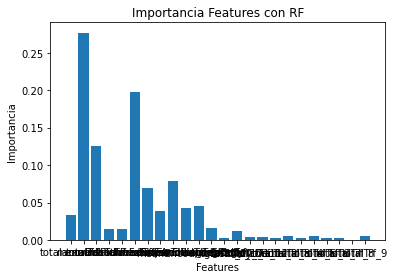

In [321]:
modelo.featureImportancia( X_train )

# aca vamos a entrenar y predecir con el test para subir a kaggle

# TERRITORY

In [322]:
test=pd.read_csv('test.csv')

In [323]:
testFeature=modelo.featureEngeenier(test)
testFeature.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf
0,10689,367419.0,0,0.0,3,3,0,2592000.0,0.0,0
1,10690,757783.5,1,0.2,5,5,1,2367360.0,0.2,5
2,10691,21037.5,0,0.0,1,1,0,0.0,0.0,0
3,10692,2169106.5,6,1.0,6,6,1,0.0,6.0,36
4,10693,5752.5,0,0.0,1,1,0,0.0,0.0,0


In [324]:
#agrego columnas temporales
ttest = pd.read_csv('test.csv')
dft=ttest
dft['Month']=pd.to_datetime(dft['Month'])
dft['anio']=dft['Month'].dt.year
dft['mes']=dft['Month'].dt.month
 

In [325]:
opMesTest=dft.groupby(['Opportunity_ID','mes']).agg(unificando=('mes','count')).reset_index()[['Opportunity_ID', 	'mes' 	]]
opMesTest

,Opportunity_ID,mes
0,10689,5
1,10690,6
2,10691,10
3,10692,12
4,10693,5
...,...,...
1836,12364,5
1837,12365,10
1838,12366,10
1839,12367,8


In [326]:
#mer=pd.merge(mes_cant_stage,opMesTest,on='mes',how='right')

In [327]:
#mer=mer.astype(str)

In [328]:
#mer2=mer.groupby(['Opportunity_ID','mes']).agg({'cant_Closed_Lost_by_mes':'sum','cant_Closed_Won_by_mes':'sum'}).unstack().fillna(0)

In [329]:
#level0=mer2.columns.get_level_values(0)
#level1=mer2.columns.get_level_values(1)
 
#mer2.columns = level0 + '_' + level1

In [330]:
#mer2=mer2.reset_index()

In [331]:
#mer2=mer2.astype(int)

In [332]:
# fin de agregar columnas temporales

In [333]:
def meanEncodingDejandoColumnaCategorica(columnsCategory):
  """devuelve un dataframe con el formato [columnscategory,meanencodingcategory]
    es porque lo vamos a usar para hacer merge por su columna categorica"""
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnsCategory,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnsCategory,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnsCategory]).agg(meanEncodingTerritory = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnsCategory]).agg(cant=(columnsCategory,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnsCategory,how='inner')
  result.head()
  del result['cant']
  result2=result[[columnsCategory,'meanEncodingTerritory']].drop_duplicates()
  return  result2

In [334]:
dfMeanEncoding=meanEncodingDejandoColumnaCategorica("Territory")
dfMeanEncoding.head()

,Territory,meanEncodingTerritory
0,None,0.535927
1867,NW America,0.632723
2745,India,0.457227
3425,Italy,0.432692
3633,Germany,0.548148


In [335]:
testAux=test.groupby(['Opportunity_ID','Territory' ]).agg(cant=('Opportunity_ID','count')).reset_index()[['Opportunity_ID','Territory' ]]
testAux.head()

,Opportunity_ID,Territory
0,10689,Germany
1,10690,Germany
2,10691,NE America
3,10692,NW America
4,10693,NW America


In [336]:
territories=pd.merge(testAux,dfMeanEncoding, on="Territory", how='left') 
territories

,Opportunity_ID,Territory,meanEncodingTerritory
0,10689,Germany,0.548148
1,10690,Germany,0.548148
2,10691,NE America,0.347490
3,10692,NW America,0.632723
4,10693,NW America,0.632723
...,...,...,...
1562,12364,KSA,0.416667
1563,12365,SE America,0.367953
1564,12366,SE America,0.367953
1565,12367,NE America,0.347490


In [337]:
 testFinal=pd.merge(testFeature,territories, on="Opportunity_ID", how='inner') 
 testFinal

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Territory,meanEncodingTerritory
0,10689,367419.0,0,0.0,3,3,0,2592000.0,0.0,0,Germany,0.548148
1,10690,757783.5,1,0.2,5,5,1,2367360.0,0.2,5,Germany,0.548148
2,10691,21037.5,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490
3,10692,2169106.5,6,1.0,6,6,1,0.0,6.0,36,NW America,0.632723
4,10693,5752.5,0,0.0,1,1,0,0.0,0.0,0,NW America,0.632723
...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,147750.0,0,0.0,2,2,0,777600.0,0.0,0,KSA,0.416667
1563,12365,45054.9,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953
1564,12366,100122.0,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953
1565,12367,143220.0,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490


# REGION

In [338]:
def meanEncodingDejandoColumnaCategorica(columnsCategory):
  """devuelve un dataframe con el formato [columnscategory,meanencodingcategory]
    es porque lo vamos a usar para hacer merge por su columna categorica"""
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnsCategory,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnsCategory,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnsCategory]).agg(meanEncodingRegion = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnsCategory]).agg(cant=(columnsCategory,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnsCategory,how='inner')
  result.head()
  del result['cant']
  result2=result[[columnsCategory,'meanEncodingRegion']].drop_duplicates()
  return  result2

In [339]:
dfMeanEncoding=meanEncodingDejandoColumnaCategorica("Region")
dfMeanEncoding.head()

,Region,meanEncodingRegion
0,EMEA,0.463392
3241,Americas,0.446166
5700,Japan,0.684350
7606,APAC,0.555556
9692,Middle East,0.239130


In [340]:
testAux=test.groupby(['Opportunity_ID','Region' ]).agg(cant=('Opportunity_ID','count')).reset_index()[['Opportunity_ID','Region' ]]
testAux.head()

,Opportunity_ID,Region
0,10689,EMEA
1,10690,EMEA
2,10691,Americas
3,10692,Americas
4,10693,Americas


In [341]:
territories=pd.merge(testAux,dfMeanEncoding, on="Region", how='left') 
territories

,Opportunity_ID,Region,meanEncodingRegion
0,10689,EMEA,0.463392
1,10690,EMEA,0.463392
2,10691,Americas,0.446166
3,10692,Americas,0.446166
4,10693,Americas,0.446166
...,...,...,...
1562,12364,EMEA,0.463392
1563,12365,Americas,0.446166
1564,12366,Americas,0.446166
1565,12367,Americas,0.446166


In [342]:
 testFinal=pd.merge(testFinal,territories, on="Opportunity_ID", how='inner') 
 testFinal

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Territory,meanEncodingTerritory,Region,meanEncodingRegion
0,10689,367419.0,0,0.0,3,3,0,2592000.0,0.0,0,Germany,0.548148,EMEA,0.463392
1,10690,757783.5,1,0.2,5,5,1,2367360.0,0.2,5,Germany,0.548148,EMEA,0.463392
2,10691,21037.5,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490,Americas,0.446166
3,10692,2169106.5,6,1.0,6,6,1,0.0,6.0,36,NW America,0.632723,Americas,0.446166
4,10693,5752.5,0,0.0,1,1,0,0.0,0.0,0,NW America,0.632723,Americas,0.446166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,147750.0,0,0.0,2,2,0,777600.0,0.0,0,KSA,0.416667,EMEA,0.463392
1563,12365,45054.9,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953,Americas,0.446166
1564,12366,100122.0,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953,Americas,0.446166
1565,12367,143220.0,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490,Americas,0.446166


# Delivery_Terms

In [343]:
def meanEncodingDejandoColumnaCategorica(columnsCategory):
  """devuelve un dataframe con el formato [columnscategory,meanencodingcategory]
    es porque lo vamos a usar para hacer merge por su columna categorica"""
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnsCategory,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnsCategory,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnsCategory]).agg(meanEncodingDelivery_Terms = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnsCategory]).agg(cant=(columnsCategory,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnsCategory,how='inner')
  result.head()
  del result['cant']
  result2=result[[columnsCategory,'meanEncodingDelivery_Terms']].drop_duplicates()
  return  result2

In [344]:
dfMeanEncoding=meanEncodingDejandoColumnaCategorica("Delivery_Terms")
dfMeanEncoding.head()

,Delivery_Terms,meanEncodingDelivery_Terms
0,Delivery_Terms_2,0.479801
3221,Delivery_Terms_4,0.547011
6690,Delivery_Terms_1,0.449874
8694,Delivery_Terms_5,0.666667
9219,Delivery_Terms_8,0.570175


In [345]:
testAux=test.groupby(['Opportunity_ID','Delivery_Terms' ]).agg(cant=('Opportunity_ID','count')).reset_index()[['Opportunity_ID','Delivery_Terms' ]]
testAux.head()

,Opportunity_ID,Delivery_Terms
0,10689,Delivery_Terms_2
1,10690,Delivery_Terms_2
2,10691,Delivery_Terms_4
3,10692,Delivery_Terms_4
4,10693,Delivery_Terms_4


In [346]:
territories=pd.merge(testAux,dfMeanEncoding, on="Delivery_Terms", how='left') 
territories

,Opportunity_ID,Delivery_Terms,meanEncodingDelivery_Terms
0,10689,Delivery_Terms_2,0.479801
1,10690,Delivery_Terms_2,0.479801
2,10691,Delivery_Terms_4,0.547011
3,10692,Delivery_Terms_4,0.547011
4,10693,Delivery_Terms_4,0.547011
...,...,...,...
1562,12364,Delivery_Terms_7,0.527778
1563,12365,Delivery_Terms_4,0.547011
1564,12366,Delivery_Terms_4,0.547011
1565,12367,Delivery_Terms_4,0.547011


In [347]:
 testFinal=pd.merge(testFinal,territories, on="Opportunity_ID", how='inner') 
 testFinal

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Territory,meanEncodingTerritory,Region,meanEncodingRegion,Delivery_Terms,meanEncodingDelivery_Terms
0,10689,367419.0,0,0.0,3,3,0,2592000.0,0.0,0,Germany,0.548148,EMEA,0.463392,Delivery_Terms_2,0.479801
1,10690,757783.5,1,0.2,5,5,1,2367360.0,0.2,5,Germany,0.548148,EMEA,0.463392,Delivery_Terms_2,0.479801
2,10691,21037.5,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490,Americas,0.446166,Delivery_Terms_4,0.547011
3,10692,2169106.5,6,1.0,6,6,1,0.0,6.0,36,NW America,0.632723,Americas,0.446166,Delivery_Terms_4,0.547011
4,10693,5752.5,0,0.0,1,1,0,0.0,0.0,0,NW America,0.632723,Americas,0.446166,Delivery_Terms_4,0.547011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,147750.0,0,0.0,2,2,0,777600.0,0.0,0,KSA,0.416667,EMEA,0.463392,Delivery_Terms_7,0.527778
1563,12365,45054.9,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953,Americas,0.446166,Delivery_Terms_4,0.547011
1564,12366,100122.0,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953,Americas,0.446166,Delivery_Terms_4,0.547011
1565,12367,143220.0,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490,Americas,0.446166,Delivery_Terms_4,0.547011


# Account_Owner

In [348]:
def meanEncodingDejandoColumnaCategorica(columnsCategory):
  """devuelve un dataframe con el formato [columnscategory,meanencodingcategory]
    es porque lo vamos a usar para hacer merge por su columna categorica"""
  df = pd.read_csv('data.csv')
  entrenamiento = pd.read_csv('data.csv')
  df = df.replace('Closed Won', '1')
  df = df.replace('Closed Lost', '0')
  df = df[df['Stage'].isin(['0','1'])]
  df.Stage = df.Stage.astype(int)
  df = df.groupby([columnsCategory,'Opportunity_ID']).agg({'Stage':['sum','count']})
  df = df.reset_index()
  df1 = df
  df1.columns = [columnsCategory,'Opportunity_ID','Stage_sum','Stage_count']
  df1['Stage_sum'] = df1['Stage_sum'].apply(lambda x: 0 if x == 0 else 1)
  df2 = df1.groupby([columnsCategory]).agg(meanEncodingAccount_Owner = ('Stage_sum','mean'))
  df2 = df2.reset_index()
  agruparOportunity=entrenamiento.groupby(['Opportunity_ID',columnsCategory]).agg(cant=(columnsCategory,'count')).reset_index()
  result=pd.merge(agruparOportunity,df2,on=columnsCategory,how='inner')
  result.head()
  del result['cant']
  result2=result[[columnsCategory,'meanEncodingAccount_Owner']].drop_duplicates()
  return  result2

In [349]:
dfMeanEncoding=meanEncodingDejandoColumnaCategorica("Account_Owner")
dfMeanEncoding.head()

,Account_Owner,meanEncodingAccount_Owner
0,Person_Name_51,0.314607
89,Person_Name_64,0.689320
505,Person_Name_8,0.571654
1140,Person_Name_50,0.633037
2158,Person_Name_60,0.288462


In [350]:
testAux=test.groupby(['Opportunity_ID','Account_Owner' ]).agg(cant=('Opportunity_ID','count')).reset_index()[['Opportunity_ID','Account_Owner' ]]
testAux.head()

,Opportunity_ID,Account_Owner
0,10689,Person_Name_13
1,10690,Person_Name_13
2,10691,Person_Name_9
3,10692,Person_Name_8
4,10693,Person_Name_64


In [351]:
#territories=pd.merge(testAux,dfMeanEncoding, on="Account_Owner", how='left') 
#territories

In [352]:
 #testFinal=pd.merge(testFinal,territories, on="Opportunity_ID", how='inner') 
 #testFinal

In [353]:
#agrego columnas men trf

In [354]:
 
df=test
df['Month']=pd.to_datetime(df['Month'])
df['anio']=df['Month'].dt.year
df['mes']=df['Month'].dt.month
#mes_cant_stage

In [355]:
df['mes']=df['mes'].astype(str) 

In [356]:
mesTrf=df.groupby(['Opportunity_ID','mes' ]).agg(totalTrf=('TRF','sum')).unstack().fillna(0)

In [357]:
level0=mesTrf.columns.get_level_values(0)
level1=mesTrf.columns.get_level_values(1)

In [358]:
mesTrf.columns = level0 + '_' +  level1

In [359]:
mesTrf=mesTrf.reset_index() 
 

In [360]:
testFinal=pd.merge(testFinal,mesTrf, on="Opportunity_ID", how='inner') 
testFinal

,Opportunity_ID,totalamount,totalTrf,meanTrf,cantTrf,cantProducFamilias,maxTrf,meanDisPlannedStarAndPlannedEnd,meanTrfporTotalTrf,cantProducFamiliasporTotalTrf,Territory,meanEncodingTerritory,Region,meanEncodingRegion,Delivery_Terms,meanEncodingDelivery_Terms,totalTrf_1,totalTrf_10,totalTrf_11,totalTrf_12,totalTrf_2,totalTrf_3,totalTrf_4,totalTrf_5,totalTrf_6,totalTrf_7,totalTrf_8,totalTrf_9
0,10689,367419.0,0,0.0,3,3,0,2592000.0,0.0,0,Germany,0.548148,EMEA,0.463392,Delivery_Terms_2,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10690,757783.5,1,0.2,5,5,1,2367360.0,0.2,5,Germany,0.548148,EMEA,0.463392,Delivery_Terms_2,0.479801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10691,21037.5,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490,Americas,0.446166,Delivery_Terms_4,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10692,2169106.5,6,1.0,6,6,1,0.0,6.0,36,NW America,0.632723,Americas,0.446166,Delivery_Terms_4,0.547011,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10693,5752.5,0,0.0,1,1,0,0.0,0.0,0,NW America,0.632723,Americas,0.446166,Delivery_Terms_4,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,147750.0,0,0.0,2,2,0,777600.0,0.0,0,KSA,0.416667,EMEA,0.463392,Delivery_Terms_7,0.527778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1563,12365,45054.9,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953,Americas,0.446166,Delivery_Terms_4,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,12366,100122.0,0,0.0,1,1,0,7862400.0,0.0,0,SE America,0.367953,Americas,0.446166,Delivery_Terms_4,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1565,12367,143220.0,0,0.0,1,1,0,0.0,0.0,0,NE America,0.347490,Americas,0.446166,Delivery_Terms_4,0.547011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [361]:
listColumns=testFinal.columns.to_list()
listColumns.remove('Territory')
listColumns.remove('Region')
listColumns.remove('Delivery_Terms')
#listColumns.remove('Account_Owner')
listColumns.remove('Opportunity_ID')
listColumns
testFinal=testFinal[listColumns]

In [362]:
#X_train, y_test se sacan del df entrenamiento

In [363]:
testFinal=testFinal.fillna(0)

In [364]:
#guardo el test para despues usarlo
dicAcumTrainAndTest['test']=testFinal

In [365]:
prediccion=modelo.entrenarYPredecirWithTest(X_train,y_train,testFinal)

In [366]:
len(prediccion)

1567

diccioanrio para guardar los dfkaggle de cada modelo para hacer ensamble

In [367]:
dicAcumulaDfKaggle={}

# **ahora vamos a hacer del xgboost optimizado y ramdomforest optimizado

In [368]:
entrenamientoFeatures=dicAcumTrainAndTest.get('entrenamiento')

In [369]:
testFeatures=dicAcumTrainAndTest.get('test')

In [370]:
modelo=modelos.get('xgboostOptimo')

#cargamos el modelo 
modelo=modelo
print(modelo.nombre)

XGBOOSTopti


In [371]:
X,Y=modelo.splitTrainTarget(entrenamientoFeatures)
modelo.buscaMejorHiperparametroAndTrainModeloWithKfold(X,Y)
prediccion=modelo.entrenarYPredecirWithTest(testFeatures) 

las columnas del train son Index(['totalamount', 'totalTrf', 'meanTrf', 'cantTrf', 'cantProducFamilias',
       'maxTrf', 'meanDisPlannedStarAndPlannedEnd', 'meanTrfporTotalTrf',
       'cantProducFamiliasporTotalTrf', 'meanEncodingTerritory',
       'meanEncodingRegion', 'meanEncodingDelivery_Terms', 'totalTrf_1',
       'totalTrf_10', 'totalTrf_11', 'totalTrf_12', 'totalTrf_2', 'totalTrf_3',
       'totalTrf_4', 'totalTrf_5', 'totalTrf_6', 'totalTrf_7', 'totalTrf_8',
       'totalTrf_9'],
      dtype='object') y del target son  Stage
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   41.6s finished



 Time taken: 0 hours 0 minutes and 47.44 seconds.

 All results:
{'mean_fit_time': array([ 7.89322527, 13.3587652 , 12.33080888,  9.62396312,  9.23191571]), 'std_fit_time': array([0.17288332, 0.30228282, 0.15040562, 0.08139769, 0.75342472]), 'mean_score_time': array([0.03783607, 0.10782766, 0.14590565, 0.04293021, 0.06775816]), 'std_score_time': array([0.00290286, 0.00826791, 0.00642513, 0.00627933, 0.02299497]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, Fal

In [372]:
dicAcumulaDfKaggle[modelo.nombre]=modelo.formarDfKaggle(prediccion)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#ramdomoforestoptimo

In [373]:
entrenamientoFeatures=dicAcumTrainAndTest.get('entrenamiento')

In [374]:
testFeatures=dicAcumTrainAndTest.get('test')

In [375]:
modelo=modelos.get('RandomForestRegreOptimo')

#cargamos el modelo 
modelo=modelo
print(modelo.nombre)

RAMDOMOptimizado


In [376]:
X,Y=modelo.splitTrainTarget(entrenamientoFeatures)
modelo.buscaMejorHiperparametroAndTrainModeloWithKfold(X,Y)
prediccion=modelo.entrenarYPredecirWithTest(testFeatures) 

las columnas del train son Index(['totalamount', 'totalTrf', 'meanTrf', 'cantTrf', 'cantProducFamilias',
       'maxTrf', 'meanDisPlannedStarAndPlannedEnd', 'meanTrfporTotalTrf',
       'cantProducFamiliasporTotalTrf', 'meanEncodingTerritory',
       'meanEncodingRegion', 'meanEncodingDelivery_Terms', 'totalTrf_1',
       'totalTrf_10', 'totalTrf_11', 'totalTrf_12', 'totalTrf_2', 'totalTrf_3',
       'totalTrf_4', 'totalTrf_5', 'totalTrf_6', 'totalTrf_7', 'totalTrf_8',
       'totalTrf_9'],
      dtype='object') y del target son  Stage
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   18.9s finished



 Time taken: 0 hours 0 minutes and 28.41 seconds.

 All results:
{'mean_fit_time': array([18.2193114 ,  0.57649255,  0.92674661,  0.53814848,  0.87893573]), 'std_fit_time': array([0.12327115, 0.10148576, 0.0972606 , 0.00467889, 0.01995728]), 'mean_score_time': array([0.62611159, 0.04378668, 0.04841638, 0.03185614, 0.04642089]), 'std_score_time': array([0.09834138, 0.0040175 , 0.00320854, 0.00339778, 0.00526073]), 'param_n_estimators': masked_array(data=[1000, 50, 50, 50, 50],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[3, 4, 5, 5, 3],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[2, 1, 2, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=[10, 7, 7, 8, 7],
             mask=[Fal

In [377]:
dicAcumulaDfKaggle[modelo.nombre]=modelo.formarDfKaggle(prediccion)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [378]:
#vamos a ensamblar
sumPrediction=0
totalModelos=0
for i in dicAcumulaDfKaggle:
  totalModelos= totalModelos +1
  sumPrediction =  sumPrediction+  dicAcumulaDfKaggle.get(i)['Target']

print(totalModelos)
print(sumPrediction)
promedio=sumPrediction/totalModelos  
 
 
#esta prediccion tiene error de aproximacion, por eso no subir este df al kaggle, ahora en la siguientes lineas lo arreglamo
#eerror es que da mayor a 1 y vaces menor a 0 y la probabilida es entre 0 y 1
prediccionFinal=modelo.formarDfKaggle( promedio )

2
0       1.324333
1       1.301657
2       1.535569
3       1.398481
4       1.872951
          ...   
1562    1.555498
1563    0.936946
1564    0.497759
1565    0.861729
1566    0.119145
Name: Target, Length: 1567, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [379]:
#aca arreglamos el error
prediccionFinal['Target'] = (
    np.select(
        condlist=[prediccionFinal['Target'] > 1, prediccionFinal['Target'] < 0], 
        choicelist=[1, 0],
        default=prediccionFinal['Target'] ))
         

In [381]:
#ahora si formamos el df a kaggle final
prediccionFinal=modelo.formarDfKaggle( prediccionFinal['Target'] )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>